In [1]:
#import modules
import csv
from ipywidgets import *
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
%matplotlib inline

# Change galaxy name and filters

In [2]:
#name of galaxy
prefix ='NGC4490'
band1 ='F555W'
band2 ='F814W'

#read in photometry files and create pandas dataframes with header names from first row
photometryFile = "%s.phot2" % prefix
photDF = pd.read_csv(photometryFile, delim_whitespace=True, header=0) 

In [3]:
#read in completeness file
fakeFile = '%s.phot.fake2' % prefix
fakeDF = pd.read_csv(fakeFile, delim_whitespace=True, header=0) 

In [4]:
#create easier names for V and I photometry
realV = photDF.inst_vega_V
realVErr = photDF.Verr
realI = photDF.inst_vega_I
realIErr = photDF.Ierr

(0, 4100)

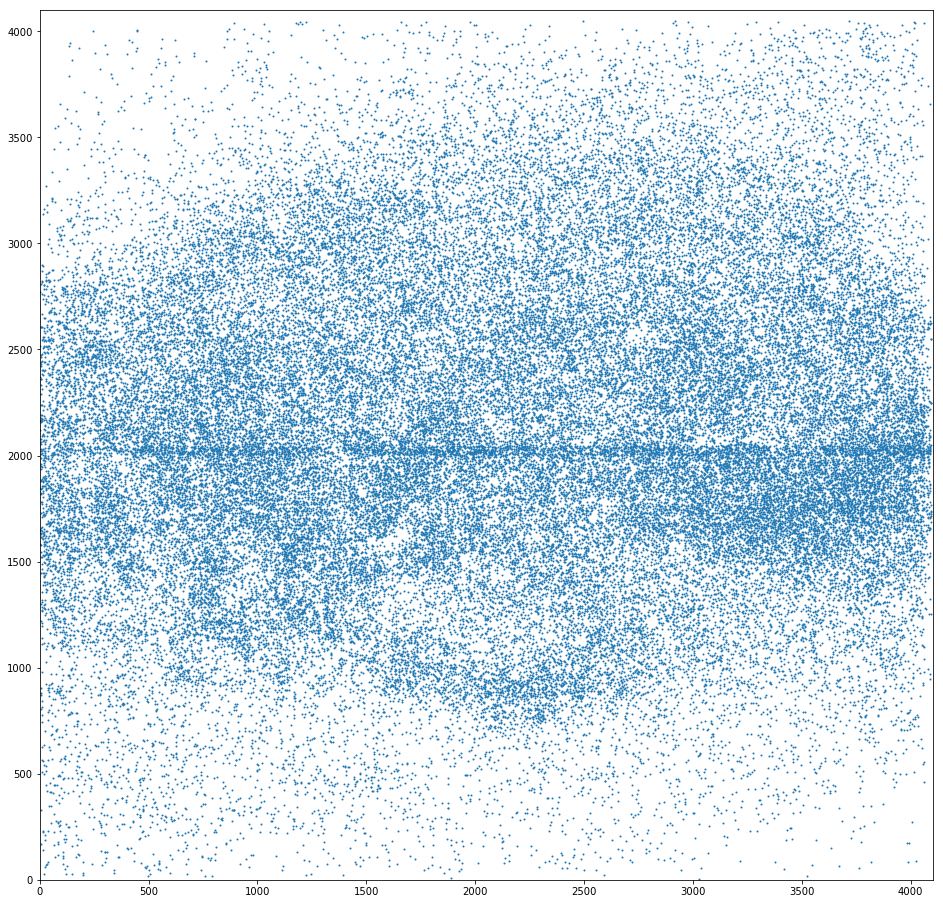

In [5]:
#show xy  plot
figure = plt.figure(figsize=(16,16))
plt.scatter(photDF.x,photDF.y,s=1)
plt.xlim(0,4100)
plt.ylim(0,4100)

# Select blue stars in CMD

In [6]:
#CMD and blue stellar line

x = np.arange(-1,3,0.01)

mSlider = widgets.FloatSlider(value=-5, min=-10, max=0, step=0.1,continuous_update=True)
bSlider = widgets.FloatSlider(value=28, min=20, max=30, step=0.1,continuous_update=True)

def pltLine(m,b):
    fig = plt.figure(figsize=(7,11))
    plt.plot(x,(m*x)+b,color='blue')
    plt.scatter(realV-realI,realI,s=0.5,color='black')
    plt.ylim(28,21)
    plt.xlim(-1,3)
    plt.show()
    
widget = interact(pltLine, m=mSlider, b=bSlider)

In [7]:
bluePhot = photDF[photDF['inst_vega_I'] < 
       ((mSlider.value)*(photDF['inst_vega_V']-photDF['inst_vega_I'])+(bSlider.value))]

# Change nbins and threshold if desired, and imsize (for different cameras)

In [8]:
#histogram definition
nbins = 82
imsize = 4096
thresh = 0 #density threshold

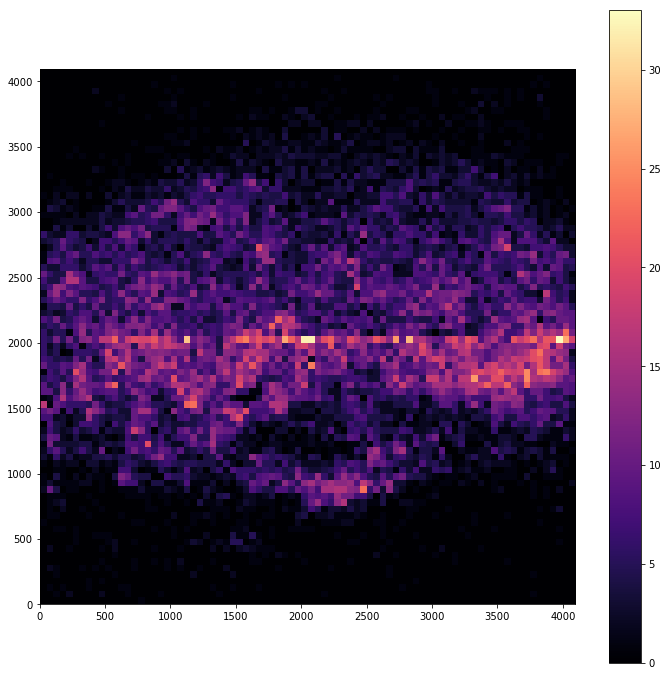

In [9]:
xyrange = [[0,imsize],[0,imsize]] # data range
bins = [nbins,nbins] # number of bins

xdat = bluePhot.x
ydat = bluePhot.y

# histogram the data
hh, locx, locy = scipy.histogram2d(xdat, ydat, range=xyrange, bins=bins)
posx = np.digitize(xdat, locx)
posy = np.digitize(ydat, locy)

#select points within the histogram
ind = (posx > 0) & (posx <= bins[0]) & (posy > 0) & (posy <= bins[1])
hhsub = hh[posx[ind] - 1, posy[ind] - 1] # values of the histogram where the points are
xdat1 = xdat[ind][hhsub < thresh] # low density points
ydat1 = ydat[ind][hhsub < thresh]
hh[hh < thresh] = np.nan # fill the areas with low density by NaNs

fig = plt.figure(figsize=(12,12))
plt.imshow(np.flipud(hh.T), cmap='magma',extent=np.array(xyrange).flatten(), interpolation='none')
plt.colorbar()   
plt.plot(xdat1, ydat1, '.',color='darkblue')
plt.show()

# Define a threshold for # of blue stars for acceptance

In [10]:
#define a threshold for acceptance
acceptThresh = 1

In [11]:
#create a new column for acceptance
photDF = photDF.assign(valid = 0)

for i in range(len(photDF)):
    #extract coordinate of each star
    xCoord = photDF.x[i]
    yCoord = photDF.y[i]
    
    #determine which bin the star lies within
    x_hh = int(np.floor(xCoord/(imsize/nbins)))
    y_hh = int(np.floor(yCoord/(imsize/nbins)))
        
    if hh[x_hh,y_hh] <= acceptThresh:
        photDF.set_value(i,'valid',1)
        
    elif np.isfinite(hh[x_hh,y_hh]) == False:
        photDF.set_value(i,'valid',1)
    
    elif hh[x_hh,y_hh] > acceptThresh:
        photDF.set_value(i,'valid',0)
        
photDFselected = photDF[(photDF['valid'] == 1)]

# Apply an overall spatial cut (optional, otherwise set to full imsize)

In [12]:
#apply a last generic spatial cut
xLow  = 0
xHigh = 4100
yLow  = 0
yHigh = 4100

photDFselected = photDFselected[(photDFselected['x'] > xLow) & (photDFselected['x'] < xHigh) 
        & (photDFselected['y'] > yLow) & (photDFselected['y'] < yHigh)]

realVselected = photDFselected.inst_vega_V
realIselected = photDFselected.inst_vega_I

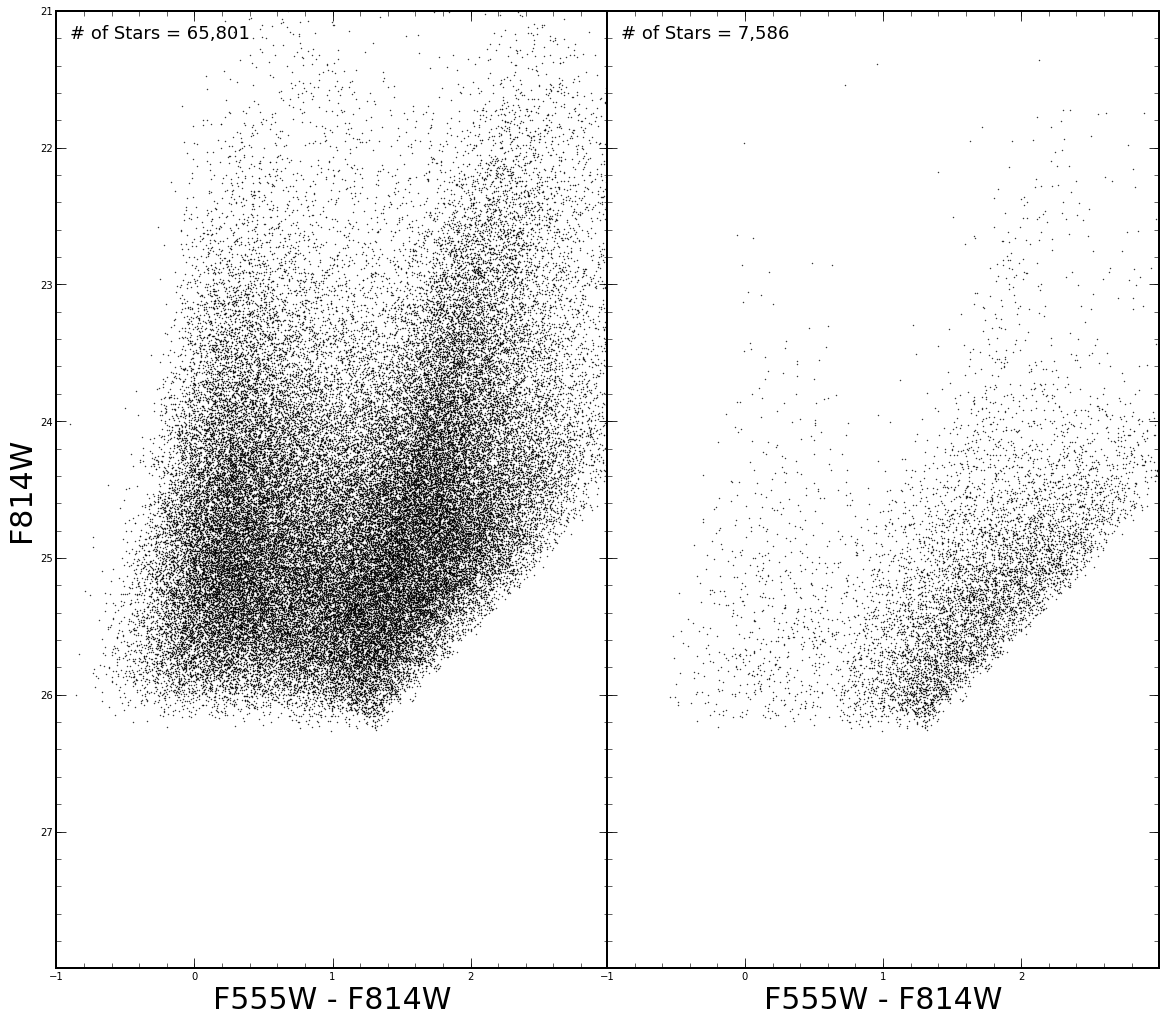

In [13]:
#set up plot
f, axarr = plt.subplots(1,2, sharey='row',  gridspec_kw = {'height_ratios':[1]})
f.set_figheight(14)
f.set_figwidth(16)


#first plot
axarr[0].plot(realV-realI,realI,'o',markersize=.4, color='black', rasterized=True)

#second plot
axarr[1].plot(realVselected-realIselected,realIselected,'o',markersize=.4, color='black', rasterized=True)


#tick and axes details
xMajorTicks = np.arange(-1, 3.0, 1.0)                                              
xMinorTicks = np.arange(-1, 3.5, 0.2)     
yMajorTicks = np.arange(21, 28, 1.0)                                              
yMinorTicks = np.arange(21, 28, 0.2) 
axarr[0].set_ylabel(band2, fontsize=30)
for i in range(2):
    axarr[i].set_xticks(xMajorTicks)                                                       
    axarr[i].set_xticks(xMinorTicks, minor=True)                                           
    axarr[i].set_yticks(yMajorTicks)                                                       
    axarr[i].set_yticks(yMinorTicks, minor=True)  
    axarr[i].xaxis.set_ticks_position('both')
    axarr[i].yaxis.set_ticks_position('both')
    axarr[i].set_xlim((-1,3.0))
    axarr[i].set_ylim((28,21))
plt.rcParams['xtick.major.size'] = 20
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 20
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['ytick.minor.width'] = 1
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24) 
axarr[0].set_xlabel("%s - %s" %(band1,band2), fontsize=30)
axarr[1].set_xlabel("%s - %s" %(band1,band2), fontsize=30)


#testing axes fixes
for i in range (0,2):
        axarr[i].xaxis.set_ticks_position('both')
        axarr[i].yaxis.set_ticks_position('both')
        axarr[i].tick_params(axis='both', direction='in', which='major', length=10)
        axarr[i].tick_params(axis='both', direction='in', which='minor', length=5)
axarr[0].label_outer()
axarr[1].label_outer()
for axis in ['top','bottom','left','right']:
    axarr[0].spines[axis].set_linewidth(2)
    axarr[1].spines[axis].set_linewidth(2)

    
#write text
axarr[0].text(-0.9, 21.2, '# of Stars = %s' %"{:,}".format(len(photDF)), fontsize = 18)
axarr[1].text(-0.9, 21.2, '# of Stars = %s' %"{:,}".format(len(photDFselected)), fontsize = 18)


#finish up
f.tight_layout(pad=0, w_pad=-0.9, h_pad=-1)

(0, 4100)

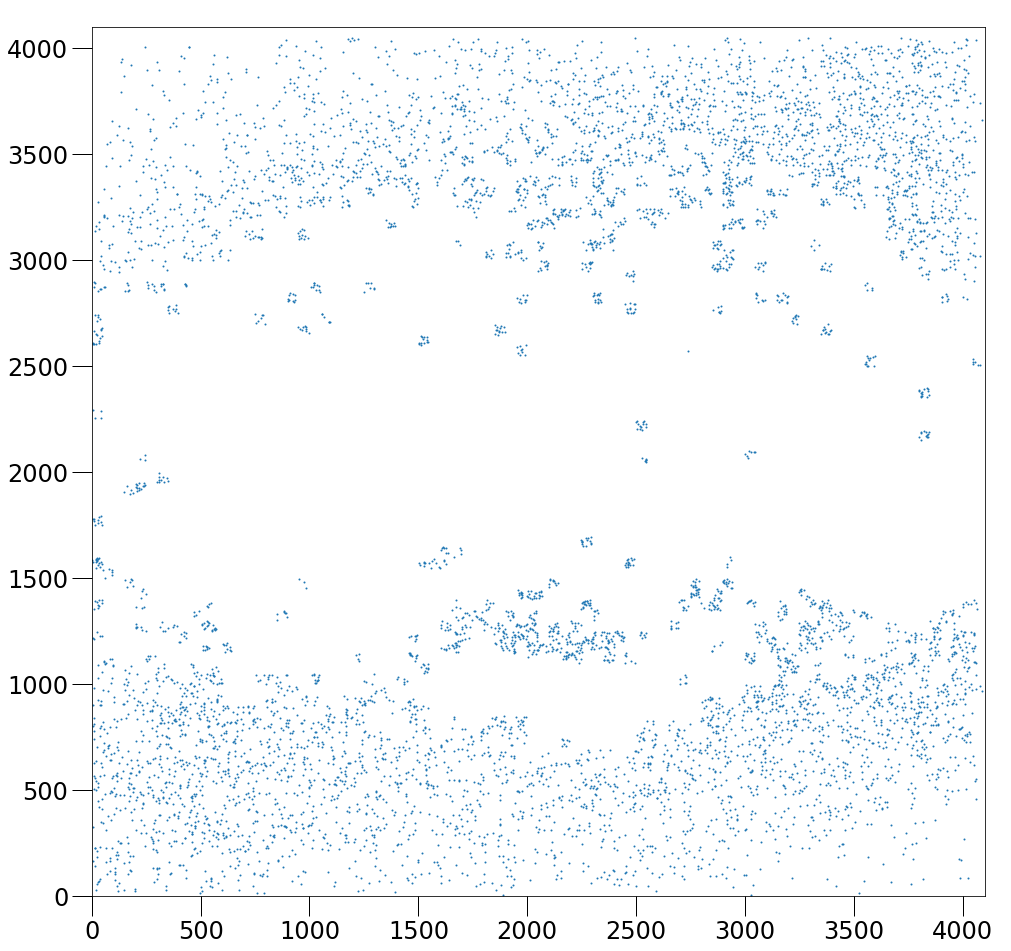

In [14]:
figure = plt.figure(figsize=(16,16))
plt.scatter(photDFselected.x,photDFselected.y,s=1)
plt.xlim(0,4100)
plt.ylim(0,4100)

# Write out new CMD

In [15]:
newCMD= photDFselected.to_csv('%s.phot3' % (prefix), sep=' ', header = True, index = False)

# Write out new Completeness File

In [16]:
from progressbar import ProgressBar
pbar = ProgressBar()

In [17]:
#apply same spatial cuts to artificial stars

#create a new column for acceptance
fakeDF = fakeDF.assign(valid = 0)

for i in pbar(range(len(fakeDF))):
    #extract coordinate of each star
    xCoord = fakeDF.xIn[i]
    yCoord = fakeDF.yIn[i]
    
    #determine which bin the star lies within
    x_hh = int(np.floor(xCoord/(imsize/nbins)))
    y_hh = int(np.floor(yCoord/(imsize/nbins)))
        
    if hh[x_hh,y_hh] <= acceptThresh:
        fakeDF.set_value(i,'valid',1)
        
    elif np.isfinite(hh[x_hh,y_hh]) == False:
        fakeDF.set_value(i,'valid',1)
    
    elif hh[x_hh,y_hh] > acceptThresh:
        fakeDF.set_value(i,'valid',0)

10000


100% |########################################################################|


In [18]:
fakeDFselected = fakeDF[(fakeDF['valid'] == 1)]

fakeDFselected = fakeDFselected[(fakeDFselected['xIn'] > xLow) & (fakeDFselected['xIn'] < xHigh) 
        & (fakeDFselected['yIn'] > yLow) & (fakeDFselected['yIn'] < yHigh)]

In [19]:
newFake = fakeDFselected.to_csv('%s.phot.fake3' % (prefix), sep=' ', header = True, index = False)